# Salary Prediction EDA





##DEFINE

Backgroud : Employers need to offer competitive salaries to attract right talent. Job seekers need to be aware of the prevailing wages/salaries.
Goal : Predict salaries given Industry, position, education, degree, number of years for experience and distance from metro

In [2]:
##mount google driver - data file
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##DISCOVER

###Load the data

#### Install Libraries

In [3]:
##import your libraries
import pandas as pd
from sklearn.tree import DecisionTreeRegressor  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#Author Info
__author__ = "Phanindra Chittavajhula"
__email__ = "phanindrac@gmail.com"

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
##install pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

#### Load Data

In [5]:
##Load independent variables
salpred_fea = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_features.csv')
salpred_fea.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [6]:
##review yearsExperience and Miles from Metro
salpred_fea.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


1.   Max 24 yrs experience doesn't seem to be odd (domain knowl)
2.   Max 99 miles from metro doesnt' seem to be odd
3.   0 yrs experience possible but also data error
4.   0 yrs experience possible but also data error



In [7]:
##Load dependent variable
salpred_sal = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_salaries.csv')
salpred_sal.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [8]:
##check salary details
salpred_sal.describe()

,salary
count,1000000.000000
mean,116.061818
std,38.717936
min,0.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


Salary 0 needs to be addressed

In [10]:
##join based on jobID
salpred = pd.merge(salpred_fea, salpred_sal, how = 'inner', on = 'jobId' )
salpred.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [11]:
##describe all numerical variables
salpred.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


###Clean Data

In [14]:
##look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
salpred[salpred.duplicated(keep=False)]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


No duplicate rows

In [16]:
##no salary less than or equal to 0
salpred.loc[salpred['salary'] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


Since we have huge dataset we get rid of 5 rows (out of millions)

In [18]:
##check for rows where degree is not NONE or High School and major is NONE
salpred.loc[(salpred['degree'] != 'NONE') & (salpred['major'] == 'NONE') & (salpred['degree'] != 'HIGH_SCHOOL')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
24,JOB1362684407711,COMP20,CEO,BACHELORS,NONE,WEB,12,8,202
32,JOB1362684407719,COMP1,CEO,MASTERS,NONE,OIL,7,91,165
34,JOB1362684407721,COMP31,MANAGER,DOCTORAL,NONE,HEALTH,15,14,164
40,JOB1362684407727,COMP7,VICE_PRESIDENT,MASTERS,NONE,HEALTH,8,54,141
46,JOB1362684407733,COMP53,MANAGER,DOCTORAL,NONE,AUTO,19,22,116
...,...,...,...,...,...,...,...,...,...
999958,JOB1362685407645,COMP46,JUNIOR,BACHELORS,NONE,SERVICE,24,64,79
999969,JOB1362685407656,COMP37,JUNIOR,DOCTORAL,NONE,EDUCATION,21,31,131
999987,JOB1362685407674,COMP51,CFO,MASTERS,NONE,FINANCE,1,99,124
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


In [19]:
##NONE can be legitimate value in major if it is high school
salpred.groupby(['degree','major']).size().reset_index().rename(columns={0:'count'})

,degree,major,count
0,BACHELORS,BIOLOGY,19619
1,BACHELORS,BUSINESS,19458
2,BACHELORS,CHEMISTRY,19681
3,BACHELORS,COMPSCI,19577
4,BACHELORS,ENGINEERING,19672
5,BACHELORS,LITERATURE,19421
6,BACHELORS,MATH,19262
7,BACHELORS,NONE,19498
8,BACHELORS,PHYSICS,19307
9,DOCTORAL,BIOLOGY,19405


In [20]:
##check for interactoin of varialbes - yearofexperience and miles from metro
salpred.groupby(['yearsExperience', 'milesFromMetropolis']).mean().reset_index().rename(columns={0:'count'})

,yearsExperience,milesFromMetropolis,salary
0,0,0,99.081340
1,0,1,98.488432
2,0,2,100.535897
3,0,3,98.657568
4,0,4,100.128535
...,...,...,...
2495,24,95,111.078818
2496,24,96,109.037313
2497,24,97,106.972158
2498,24,98,106.366755


### Exploratory Data Analysis (non visual)

In [21]:
##check how many companies are there; 
print(np.sort(salpred['companyId'].unique()), len(salpred['companyId'].unique()))

['COMP0' 'COMP1' 'COMP10' 'COMP11' 'COMP12' 'COMP13' 'COMP14' 'COMP15'
 'COMP16' 'COMP17' 'COMP18' 'COMP19' 'COMP2' 'COMP20' 'COMP21' 'COMP22'
 'COMP23' 'COMP24' 'COMP25' 'COMP26' 'COMP27' 'COMP28' 'COMP29' 'COMP3'
 'COMP30' 'COMP31' 'COMP32' 'COMP33' 'COMP34' 'COMP35' 'COMP36' 'COMP37'
 'COMP38' 'COMP39' 'COMP4' 'COMP40' 'COMP41' 'COMP42' 'COMP43' 'COMP44'
 'COMP45' 'COMP46' 'COMP47' 'COMP48' 'COMP49' 'COMP5' 'COMP50' 'COMP51'
 'COMP52' 'COMP53' 'COMP54' 'COMP55' 'COMP56' 'COMP57' 'COMP58' 'COMP59'
 'COMP6' 'COMP60' 'COMP61' 'COMP62' 'COMP7' 'COMP8' 'COMP9'] 63


There are about 63 unique companies

In [0]:
##how many different job types are there
print(np.sort(salpred['jobType'].unique()), len(salpred['jobType'].unique()))

['CEO' 'CFO' 'CTO' 'JANITOR' 'JUNIOR' 'MANAGER' 'SENIOR' 'VICE_PRESIDENT'] 8


There are about 8 different jobtypes

In [22]:
##how many degrees are there
print(np.sort(salpred['degree'].unique()), len(salpred['degree'].unique()))

['BACHELORS' 'DOCTORAL' 'HIGH_SCHOOL' 'MASTERS' 'NONE'] 5


There are about 5 different degress

In [0]:
##how many major are there
print(np.sort(salpred['major'].unique()), len(salpred['major'].unique()))

['BIOLOGY' 'BUSINESS' 'CHEMISTRY' 'COMPSCI' 'ENGINEERING' 'LITERATURE'
 'MATH' 'NONE' 'PHYSICS'] 9


There are about 9 different majors

In [23]:
##how many industries are there
print(np.sort(salpred['industry'].unique()), len(salpred['industry'].unique()))

['AUTO' 'EDUCATION' 'FINANCE' 'HEALTH' 'OIL' 'SERVICE' 'WEB'] 7


There are about 7 different industries

In [0]:
##how many yearsExperience are there
print(np.sort(salpred['yearsExperience'].unique()), len(salpred['yearsExperience'].unique()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] 25


Experience ranging from 0 to 25 years

In [25]:
##how many milesfromMetro are there
print(np.sort(salpred['milesFromMetropolis'].unique()), len(salpred['milesFromMetropolis'].unique()))
##result : There are about 100 milesfromMetro

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99] 100


### Exploratory Data Analysis

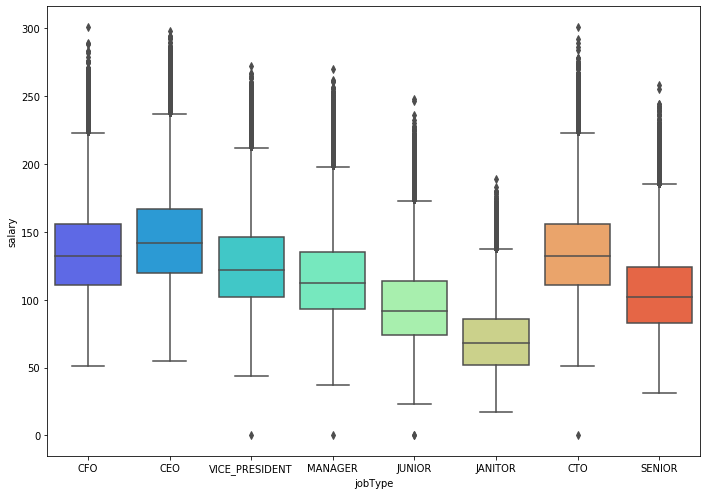

In [26]:
#summarize target variable by each categorical independent variable
#look for correlation between each feature and the target
#look for correlation between features
#sns.barplot(x='jobType',y='salary',data=salpred)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x="jobType", y="salary", data=salpred,palette='rainbow',ax=ax)
##seperating out CFO, CEO, VP and CTO into one; Manager, Senior, Junior; Janitor in last one

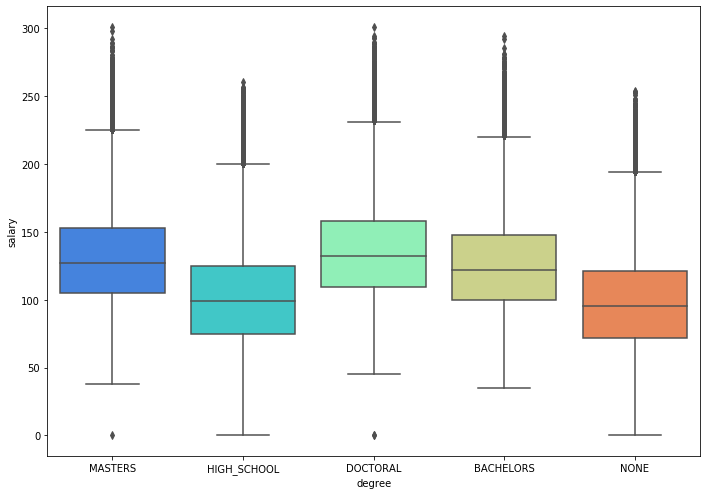

In [27]:
##check by degree
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x="degree", y="salary", data=salpred,palette='rainbow',ax=ax)

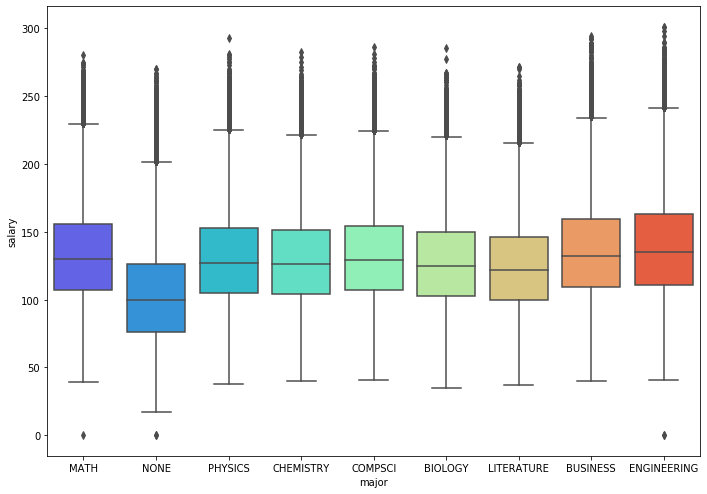

In [28]:
##check by major
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x="major", y="salary", data=salpred,palette='rainbow',ax=ax)

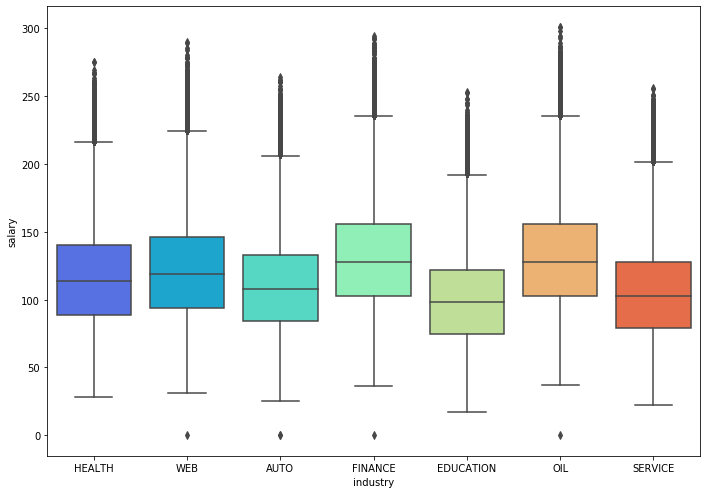

In [29]:
##check by industrt
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(x="industry", y="salary", data=salpred,palette='rainbow',ax=ax)

Salaries in Finance & Oil seem to be higher

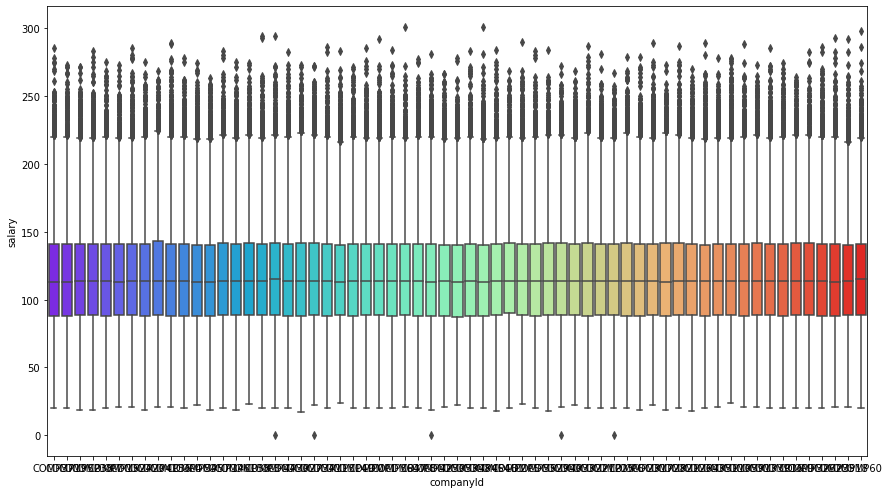

In [30]:
#check by company ID
fig, ax = plt.subplots()
fig.set_size_inches(14.7, 8.27)
sns.boxplot(x="companyId", y="salary", data=salpred,palette='rainbow',ax=ax)

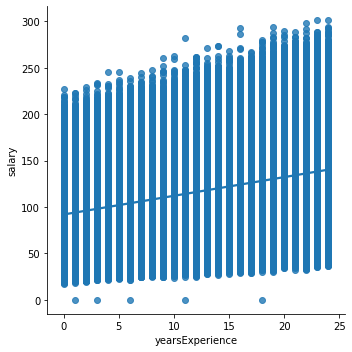

In [0]:
##check salary by yearofexperience
sns.lmplot(x='yearsExperience',y='salary',data=salpred)

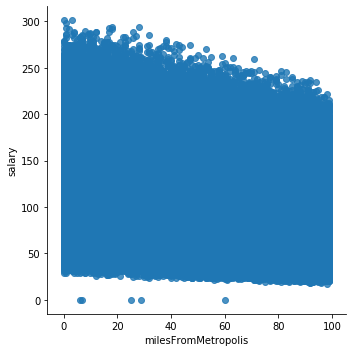

In [0]:
##check salary by miles from Metro
sns.lmplot(x='milesFromMetropolis',y='salary',data=salpred)

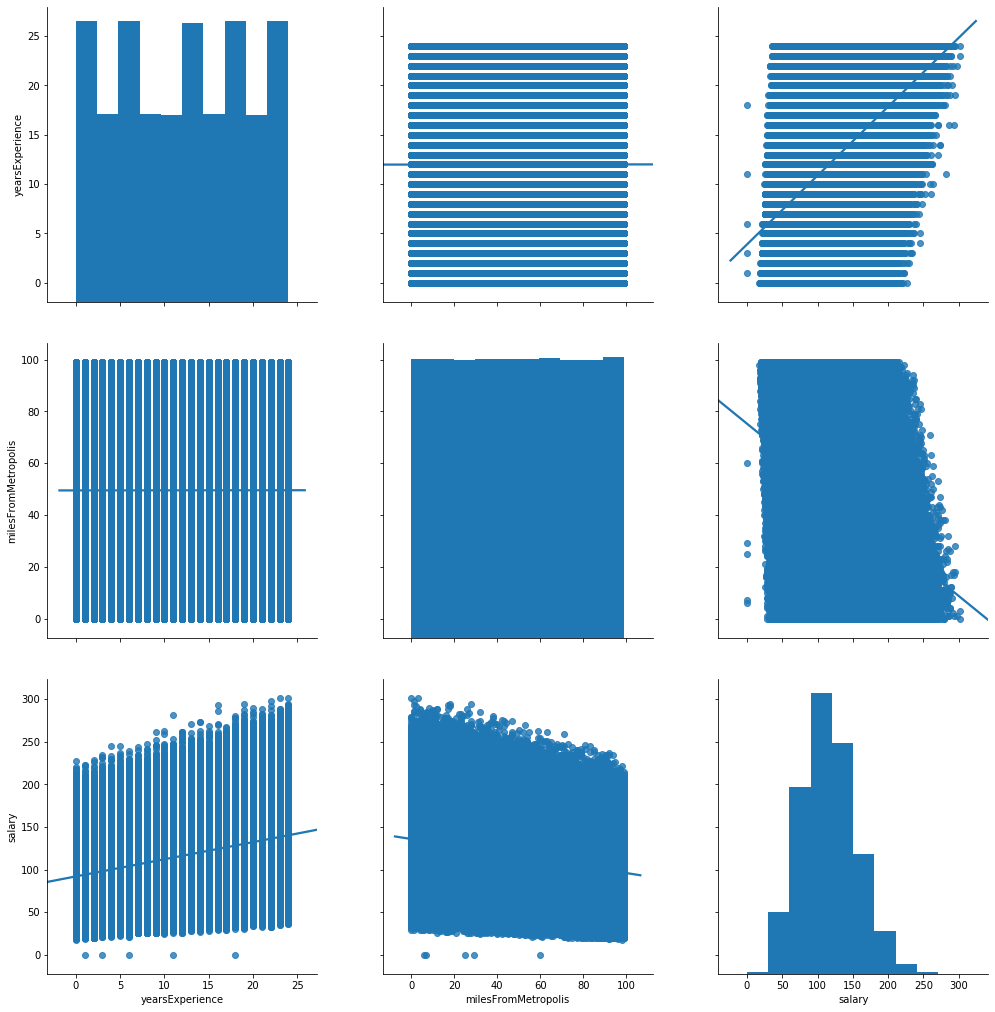

In [0]:
##scatter plot (can only done for integer or floating type variables)
g=sns.pairplot(salpred, kind='reg')
g.fig.set_size_inches(15,15)

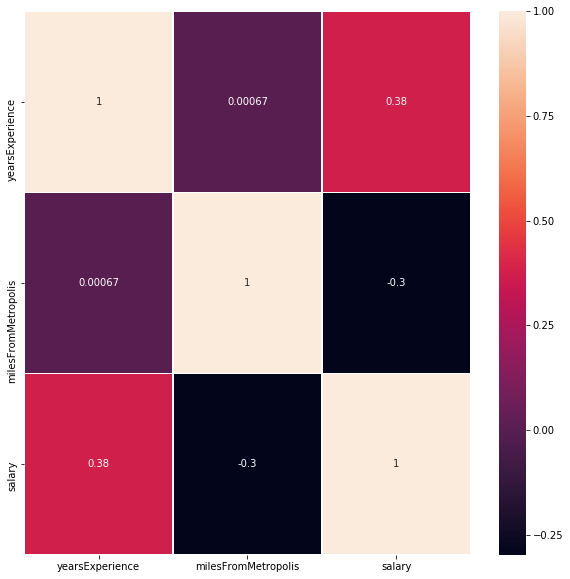

In [0]:
##using sns heatmap feature to find correlations
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(salpred.corr(), annot=True, linewidths=.5, ax=ax)

In [31]:
##copy data frame and convert categorical variables
salpred_dt = salpred
le = preprocessing.LabelEncoder()
salpred_dt_trfn = salpred_dt.apply(le.fit_transform)
salpred_dt_trfn.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,0,31,1,3,6,3,10,83,114
1,1,11,0,2,7,6,3,73,85
2,2,48,7,1,8,3,10,38,121
3,3,32,5,1,2,0,8,17,126
4,4,60,7,0,8,2,8,16,147


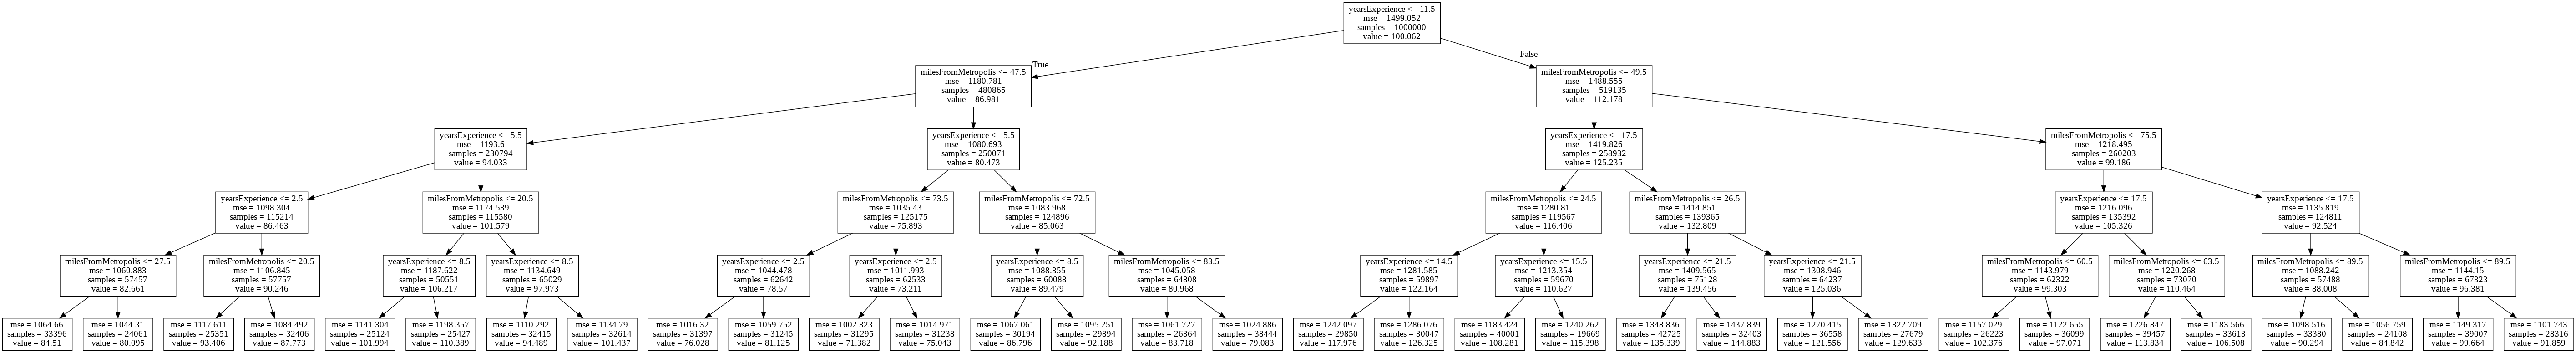

In [32]:
##Check for interaction
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0,max_depth=5)  
  
# fit the regressor with X and Y data 
X = salpred_dt_trfn[['yearsExperience','milesFromMetropolis']]
y = salpred_dt_trfn['salary']
regressor.fit(X, y) 
  
dot_data = StringIO()
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
##export_graphviz(regressor, out_file ='tree.dot', 
export_graphviz(regressor, out_file = dot_data, 
               feature_names =['yearsExperience','milesFromMetropolis'])  

##export_graphviz(regressor, out_file=dot_data
##              ,  
##              filled=True, rounded=True,
##              special_characters=True
##              )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

There is interaction between miles from Metro and years of experience

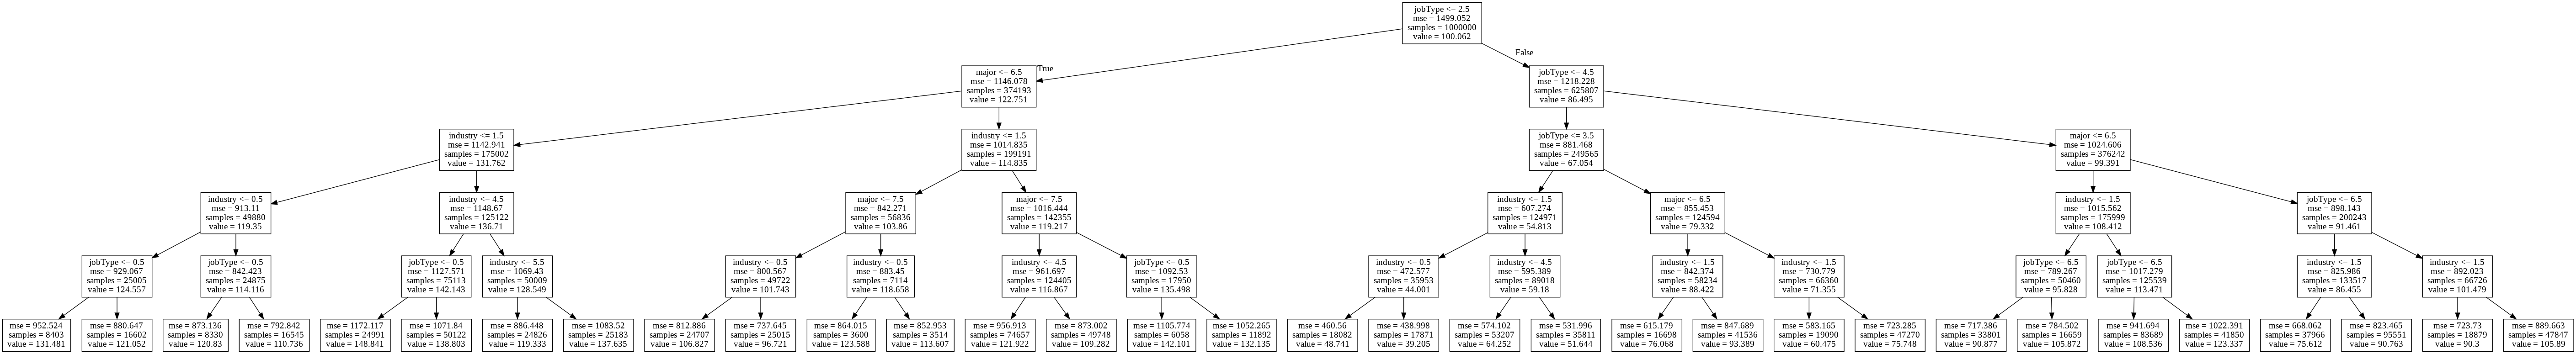

In [33]:
# import export_graphviz 
from sklearn.tree import export_graphviz  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
  
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0,max_depth=5)  
  
# fit the regressor with X and Y data 
X = salpred_dt_trfn[['jobType','degree','major','industry']]
y = salpred_dt_trfn['salary']
regressor.fit(X, y) 
  
dot_data = StringIO()
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
##export_graphviz(regressor, out_file ='tree.dot', 
export_graphviz(regressor, out_file = dot_data, 
               feature_names =['jobType','degree','major','industry'])  

##export_graphviz(regressor, out_file=dot_data
##              ,  
##              filled=True, rounded=True,
##              special_characters=True
##              )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Important variables : Per decision tree split, Jobtype; Major; Industry; Since split started here

### Establish Baseline

In [0]:
##remove salaries with 0
##remove rows where both 
salpred_train = salpred.loc[salpred['salary'] > 0]

In [47]:
##create interaction variables
salpred_train['int_yr_miles'] = salpred_train['yearsExperience'] * salpred_train['milesFromMetropolis']
salpred_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,int_yr_miles
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,830
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,219
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,380
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,136
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,128


In [48]:
##simply get average of salary by all variables. This can be important feature
Ind_Jt_Avg = salpred_train.groupby(['industry','jobType','milesFromMetropolis','yearsExperience','degree']).mean().reset_index()[['industry','jobType','milesFromMetropolis','yearsExperience','degree','salary']]
Ind_Jt_Avg

,industry,jobType,milesFromMetropolis,yearsExperience,degree,salary
0,AUTO,CEO,0,0,BACHELORS,151.5
1,AUTO,CEO,0,0,HIGH_SCHOOL,89.0
2,AUTO,CEO,0,0,NONE,112.0
3,AUTO,CEO,0,1,DOCTORAL,138.0
4,AUTO,CEO,0,1,HIGH_SCHOOL,92.0
...,...,...,...,...,...,...
499454,WEB,VICE_PRESIDENT,99,23,MASTERS,118.0
499455,WEB,VICE_PRESIDENT,99,23,NONE,108.0
499456,WEB,VICE_PRESIDENT,99,24,BACHELORS,105.0
499457,WEB,VICE_PRESIDENT,99,24,DOCTORAL,144.5


In [0]:
##add avg column to the dataframe. This is derived independent feature
salpred_bl = pd.merge(salpred_train, Ind_Jt_Avg, how = 'inner', on = ['industry','jobType','milesFromMetropolis','yearsExperience','degree'] )

In [53]:
##validate that data is correct
salpred_bl.head(100)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary_x,int_yr_miles,salary_y
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,830,129.0
1,JOB1362684644335,COMP50,CFO,MASTERS,BIOLOGY,HEALTH,10,83,154,830,129.0
2,JOB1362684661216,COMP13,CFO,MASTERS,MATH,HEALTH,10,83,110,830,129.0
3,JOB1362684856058,COMP60,CFO,MASTERS,COMPSCI,HEALTH,10,83,122,830,129.0
4,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,219,125.0
...,...,...,...,...,...,...,...,...,...,...,...
95,JOB1362684746245,COMP11,JUNIOR,MASTERS,CHEMISTRY,HEALTH,12,78,83,936,98.2
96,JOB1362684821997,COMP1,JUNIOR,MASTERS,CHEMISTRY,HEALTH,12,78,121,936,98.2
97,JOB1362685101816,COMP43,JUNIOR,MASTERS,BUSINESS,HEALTH,12,78,84,936,98.2
98,JOB1362685164204,COMP53,JUNIOR,MASTERS,PHYSICS,HEALTH,12,78,103,936,98.2


In [51]:
# The mean squared error on the entire test dataset
from sklearn.metrics import mean_squared_error
print(mean_squared_error(salpred_bl['salary_x'], salpred_bl['salary_y']))

181.36291479430523
